<a href="https://colab.research.google.com/github/SoniPrithish/Practise/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install torch torchvision transformers tqdm scikit-learn pandas matplotlib

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from PIL import Image
import requests
from io import BytesIO
import os
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import gc
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories for images
os.makedirs("images/train", exist_ok=True)
os.makedirs("images/val", exist_ok=True)

# Define paths to the dataset files
train_path = '/content/drive/MyDrive/Colab Notebooks/multimodal_only_samples/multimodal_train.tsv'
val_path = '/content/drive/MyDrive/Colab Notebooks/multimodal_only_samples/multimodal_test_public.tsv'

# Helper function to print memory usage (useful for debugging)
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")

Using device: cuda


In [ ]:
# Load and sample dataset
def load_and_sample_dataset(train_path, val_path, train_sample_size=7000, val_sample_size=1000):
    """
    Load and sample the dataset to a manageable size while maintaining class balance
    """
    # Load datasets
    print("Loading datasets...")
    train_df = pd.read_csv(train_path, sep='\t')
    val_df = pd.read_csv(val_path, sep='\t')

    # Filter out samples without images
    train_df = train_df[train_df['hasImage'] == True]
    val_df = val_df[val_df['hasImage'] == True]

    # Convert label columns to integer
    train_df['2_way_label'] = train_df['2_way_label'].astype(int)
    val_df['2_way_label'] = val_df['2_way_label'].astype(int)

    # Print full dataset information
    print(f"Full training set size: {len(train_df)}")
    print(f"Full validation set size: {len(val_df)}")

    # Check label distribution
    print("\nLabel distribution in full training set:")
    print(train_df['2_way_label'].value_counts())

    # Sample the datasets while maintaining class distribution
    train_df_sampled = pd.DataFrame()
    val_df_sampled = pd.DataFrame()

    for label in train_df['2_way_label'].unique():
        # Get subset for this label
        train_label_df = train_df[train_df['2_way_label'] == label]
        val_label_df = val_df[val_df['2_way_label'] == label]

        # Calculate number of samples per class (proportional)
        label_ratio = len(train_label_df) / len(train_df)
        train_label_size = int(train_sample_size * label_ratio)
        val_label_size = int(val_sample_size * label_ratio)

        # Make sure we have at least some samples from each class
        train_label_size = max(train_label_size, 100)
        val_label_size = max(val_label_size, 20)

        # Sample
        train_df_sampled = pd.concat([
            train_df_sampled,
            train_label_df.sample(min(train_label_size, len(train_label_df)), random_state=42)
        ])
        val_df_sampled = pd.concat([
            val_df_sampled,
            val_label_df.sample(min(val_label_size, len(val_label_df)), random_state=42)
        ])

    # Print sampled dataset information
    print(f"\nSampled training set size: {len(train_df_sampled)}")
    print(f"Sampled validation set size: {len(val_df_sampled)}")

    print("\nLabel distribution in sampled training set:")
    print(train_df_sampled['2_way_label'].value_counts())
    print("\nLabel distribution in sampled validation set:")
    print(val_df_sampled['2_way_label'].value_counts())

    return train_df_sampled, val_df_sampled

In [ ]:
# Image downloader with progress tracking and error handling
def download_images_for_df(df, output_dir, max_images=4000):
    """
    Download images only for the samples in the given dataframe, with a maximum limit
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Filter to rows with valid image URLs
    image_df = df[df["hasImage"] == True].copy()
    image_df = image_df[image_df["image_url"].notna()]
    image_df = image_df[image_df["image_url"] != ""]

    # Limit to max_images
    if len(image_df) > max_images:
        image_df = image_df.sample(max_images, random_state=42)

    print(f"Downloading up to {len(image_df)} images to {output_dir}")

    # Track already downloaded images
    already_downloaded = set(os.listdir(output_dir))
    to_download = [(idx, row) for idx, row in image_df.iterrows()
                   if f"{row['id']}.jpg" not in already_downloaded]

    print(f"Found {len(already_downloaded)} already downloaded images")
    print(f"Need to download {len(to_download)} more images")

    # Download images
    success_count = len(already_downloaded)
    error_count = 0
    start_time = time.time()

    for idx, (_, row) in enumerate(tqdm(to_download, desc="Downloading images")):
        try:
            image_url = row["image_url"]
            output_path = os.path.join(output_dir, f"{row['id']}.jpg")

            # Download the image
            response = requests.get(image_url, timeout=3)
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    f.write(response.content)
                success_count += 1

                # Report progress periodically
                if success_count % 100 == 0:
                    elapsed = time.time() - start_time
                    rate = success_count / elapsed if elapsed > 0 else 0
                    print(f"Downloaded {success_count} images ({rate:.1f} images/sec)")
            else:
                error_count += 1

        except Exception as e:
            error_count += 1

        # Early stop if we've downloaded enough
        if idx > 0 and idx % 1000 == 0:
            # Clean up memory
            gc.collect()

    print(f"Successfully downloaded {success_count} images, failed: {error_count}")
    return success_count

In [ ]:
# Custom dataset class with optimized image loading
class FakedditDataset(Dataset):
    def __init__(self, dataframe, tokenizer, img_dir, max_length=128, img_size=224, transform=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.img_dir = img_dir
        self.max_length = max_length
        self.img_size = img_size

        # Default transformations if none provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        # Initialize a blank image tensor for fallback
        self.blank_image = torch.zeros((3, img_size, img_size))

        # Create a mapping from ID to row index for faster lookup
        self.id_to_idx = {row['id']: i for i, row in dataframe.iterrows()}

        # Find which images are available locally to avoid checking each time
        self.available_images = set()
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.jpg'):
                img_id = img_file[:-4]  # Remove .jpg extension
                self.available_images.add(img_id)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process text
        title = str(row['clean_title']) if pd.notna(row['clean_title']) else ""
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Process image - first check if it's in our available images set
        row_id = str(row['id'])
        if row_id in self.available_images:
            try:
                image_path = os.path.join(self.img_dir, f"{row_id}.jpg")
                image = Image.open(image_path).convert('RGB')
                image = self.transform(image)
            except:
                image = self.blank_image
        else:
            image = self.blank_image

        # Get label
        label = torch.tensor(row['2_way_label'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'image': image,
            'label': label
        }

In [ ]:
# Image Feature Extractor using EfficientNet (more efficient than ResNet)
class ImageFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ImageFeatureExtractor, self).__init__()
        # Use EfficientNet-B0 which has a good balance of performance and size
        self.model = models.efficientnet_b0(pretrained=pretrained)

        # Remove the final classification layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])

        # Get feature dimension
        self.feature_dim = 1280  # EfficientNet-B0 feature dimension

        # Freeze parameters
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features
        with torch.no_grad():
            # Forward pass through the model
            features = self.model(x)

            # Flatten the features
            features = torch.flatten(features, 1)
        return features

# Multi-Modal Fake News Detection Model
class MultiModalFakeNewsDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(MultiModalFakeNewsDetector, self).__init__()

        # Text model (BERT)
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze BERT parameters to speed up training
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last few layers for fine-tuning
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        # Image feature extractor
        self.image_feature_extractor = ImageFeatureExtractor(pretrained=True)

        # Feature dimensions
        self.bert_dim = self.bert.config.hidden_size  # 768
        self.img_dim = self.image_feature_extractor.feature_dim  # 1280

        # Feature processing layers
        self.text_fc = nn.Sequential(
            nn.Linear(self.bert_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.img_fc = nn.Sequential(
            nn.Linear(self.img_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion and classification layers
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=4, batch_first=True)

        self.fusion_fc = nn.Sequential(
            nn.Linear(1024, 256),  # 1024 = 512 (text) + 512 (image)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, token_type_ids, images):
        # Process text with BERT
        text_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get CLS token embedding
        text_features = text_outputs.pooler_output  # [batch_size, 768]
        text_features = self.text_fc(text_features)  # [batch_size, 512]

        # Extract image features
        img_features = self.image_feature_extractor(images)  # [batch_size, 1280]
        img_features = self.img_fc(img_features)  # [batch_size, 512]

        # Use attention to combine text and image features
        text_features_unsqueezed = text_features.unsqueeze(1)  # [batch_size, 1, 512]
        img_features_unsqueezed = img_features.unsqueeze(1)    # [batch_size, 1, 512]

        # Concatenate for self-attention
        multimodal_features = torch.cat([text_features_unsqueezed, img_features_unsqueezed], dim=1)  # [batch_size, 2, 512]

        # Apply self-attention
        attn_output, _ = self.attention(multimodal_features, multimodal_features, multimodal_features)

        # Flatten and average attention output
        attn_output = attn_output.mean(dim=1)  # [batch_size, 512]

        # Concatenate original features with attention output
        combined_features = torch.cat([text_features, img_features], dim=1)  # [batch_size, 1024]

        # Final classification
        logits = self.fusion_fc(combined_features)  # [batch_size, num_classes]

        return logits

In [ ]:
# Training function with mixed precision and gradient accumulation
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=5, patience=3, gradient_accumulation_steps=4):
    """
    Train the model with mixed precision and gradient accumulation
    """
    # Initialize for mixed precision training
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    best_val_f1 = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        optimizer.zero_grad()  # Zero gradients at the start of epoch

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, batch in progress_bar:
            try:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                # Mixed precision forward pass
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(input_ids, attention_mask, token_type_ids, images)
                        loss = criterion(outputs, labels) / gradient_accumulation_steps

                    # Scale the loss and backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % gradient_accumulation_steps == 0 or batch_idx == len(train_loader) - 1:
                        # Unscales the gradients
                        scaler.unscale_(optimizer)

                        # Clip gradients to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                        # Optimizer step with scaler
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                        if scheduler is not None:
                            scheduler.step()
                else:
                    # Standard forward pass
                    outputs = model(input_ids, attention_mask, token_type_ids, images)
                    loss = criterion(outputs, labels) / gradient_accumulation_steps

                    # Backward pass
                    loss.backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % gradient_accumulation_steps == 0 or batch_idx == len(train_loader) - 1:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                        optimizer.zero_grad()

                        if scheduler is not None:
                            scheduler.step()

                # Calculate statistics
                train_loss += loss.item() * gradient_accumulation_steps * input_ids.size(0)
                with torch.no_grad():
                    _, predicted = torch.max(outputs, 1)
                    train_correct += (predicted == labels).sum().item()
                    train_total += labels.size(0)

                # Update progress bar
                progress_bar.set_postfix({
                    'loss': loss.item() * gradient_accumulation_steps,
                    'accuracy': train_correct/train_total if train_total > 0 else 0
                })

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue

        # Calculate epoch metrics
        epoch_train_loss = train_loss / train_total if train_total > 0 else float('inf')
        epoch_train_acc = train_correct / train_total if train_total > 0 else 0

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                try:
                    # Move batch to device
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    images = batch['image'].to(device)
                    labels = batch['label'].to(device)

                    # Forward pass
                    if scaler is not None:
                        with torch.cuda.amp.autocast():
                            outputs = model(input_ids, attention_mask, token_type_ids, images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(input_ids, attention_mask, token_type_ids, images)
                        loss = criterion(outputs, labels)

                    # Calculate statistics
                    val_loss += loss.item() * input_ids.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_targets.extend(labels.cpu().numpy())

                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue

        # Calculate validation metrics
        val_total = len(val_targets)
        epoch_val_loss = val_loss / val_total if val_total > 0 else float('inf')

        if val_total > 0:
            epoch_val_acc = accuracy_score(val_targets, val_preds)
            epoch_val_f1 = f1_score(val_targets, val_preds, average='weighted')
        else:
            epoch_val_acc = 0
            epoch_val_f1 = 0

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_f1'].append(epoch_val_f1)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val F1: {epoch_val_f1:.4f}")

        # Early stopping
        if epoch_val_f1 > best_val_f1:
            best_val_f1 = epoch_val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("  Model improved! Saved checkpoint.")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        # Clean up memory
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return model, history

# Evaluation function
def evaluate_model(model, test_loader):
    """
    Evaluate model performance on the test set
    """
    model.eval()
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            try:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                # Forward pass with full model
                outputs = model(input_ids, attention_mask, token_type_ids, images)
                _, predicted = torch.max(outputs, 1)

                # Store predictions and targets
                test_preds.extend(predicted.cpu().numpy())
                test_targets.extend(labels.cpu().numpy())

            except Exception as e:
                print(f"Error during evaluation: {e}")
                continue

    # Calculate metrics
    if len(test_targets) > 0:
        accuracy = accuracy_score(test_targets, test_preds)
        precision = precision_score(test_targets, test_preds, average='weighted')
        recall = recall_score(test_targets, test_preds, average='weighted')
        f1 = f1_score(test_targets, test_preds, average='weighted')

        print("\nTest Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Plot confusion matrix
        cm = confusion_matrix(test_targets, test_preds, normalize='true')
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Normalized Confusion Matrix')
        plt.colorbar()
        class_names = ['Real', 'Fake']
        plt.xticks([0, 1], class_names)
        plt.yticks([0, 1], class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # Add text annotations
        thresh = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, f"{cm[i, j]:.2f}",
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

        return accuracy, precision, recall, f1
    else:
        print("No samples were evaluated")
        return 0, 0, 0, 0

# Plot training history function
def plot_history(history):
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epochs')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [ ]:
# Load and sample datasets - adjust sample sizes based on computational resources
train_df, val_df = load_and_sample_dataset(
    train_path, val_path,
    train_sample_size=7000,
    val_sample_size=1000
)

Loading datasets...
Full training set size: 564000
Full validation set size: 59319

Label distribution in full training set:
2_way_label
0    341919
1    222081
Name: count, dtype: int64

Sampled training set size: 6999
Sampled validation set size: 999

Label distribution in sampled training set:
2_way_label
0    4243
1    2756
Name: count, dtype: int64

Label distribution in sampled validation set:
2_way_label
0    606
1    393
Name: count, dtype: int64


In [ ]:
# Define image directories
train_img_dir = "images/train"
val_img_dir = "images/val"

# Download images for the sampled datasets
# Setting max_images to ensure we stay within the 8,000 limit
train_success = download_images_for_df(train_df, train_img_dir, max_images=7000)
val_success = download_images_for_df(val_df, val_img_dir, max_images=1000)

Found 5288 already downloaded images
Need to download 6913 more images


Downloaded 5300 images (3807.6 images/sec)


Downloaded 5400 images (440.4 images/sec)


Downloaded 5500 images (221.6 images/sec)


Downloaded 5600 images (148.4 images/sec)


Downloaded 5700 images (116.1 images/sec)


Downloaded 5800 images (96.9 images/sec)


Downloaded 5900 images (83.1 images/sec)


Downloaded 6000 images (69.9 images/sec)


Downloaded 6100 images (63.3 images/sec)


Downloaded 6200 images (57.1 images/sec)


Downloaded 6300 images (52.2 images/sec)


Downloaded 6400 images (48.8 images/sec)


Downloaded 6500 images (44.8 images/sec)


Downloaded 6600 images (42.1 images/sec)


Downloaded 6700 images (40.0 images/sec)


Downloaded 6800 images (37.7 images/sec)


Downloaded 6900 images (35.7 images/sec)


Downloaded 7000 images (34.2 images/sec)


Downloaded 7100 images (32.6 images/sec)


Downloaded 7200 images (31.2 images/sec)


Downloaded 7300 images (30.1 images/sec)


Downloaded 7400 images (28.9 images/sec)


Downloaded 7500 images (28.0 images/sec)


Downloaded 7600 images (27.3 images/sec)


Downloaded 7700 images (26.3 images/sec)


Downloaded 7800 images (25.5 images/sec)


Downloaded 7900 images (24.5 images/sec)


Downloaded 8000 images (23.6 images/sec)


Downloaded 8100 images (22.9 images/sec)


Downloaded 8200 images (22.0 images/sec)


Downloaded 8300 images (21.3 images/sec)


Downloaded 8400 images (20.8 images/sec)


Downloaded 8500 images (20.2 images/sec)


Downloaded 8600 images (19.8 images/sec)


Downloaded 8700 images (19.3 images/sec)


Downloaded 8800 images (18.9 images/sec)


Downloaded 8900 images (18.5 images/sec)


Downloaded 9000 images (18.1 images/sec)


Downloaded 9100 images (17.8 images/sec)


Downloaded 9200 images (17.4 images/sec)


Downloaded 9300 images (17.0 images/sec)


Downloaded 9400 images (16.7 images/sec)


Downloaded 9500 images (16.4 images/sec)


Downloaded 9600 images (16.1 images/sec)


Downloaded 9700 images (15.9 images/sec)


Downloaded 9800 images (15.6 images/sec)


Successfully downloaded 9879 images, failed: 2322
Found 0 already downloaded images
Need to download 997 more images


Downloaded 100 images (3.3 images/sec)


Downloaded 200 images (3.2 images/sec)


Downloaded 300 images (3.2 images/sec)


Downloaded 400 images (3.1 images/sec)


Downloaded 500 images (3.1 images/sec)


Downloaded 600 images (3.2 images/sec)


Successfully downloaded 648 images, failed: 349


In [ ]:
# Initialize BERT tokenizer
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define image transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard transformations for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("Creating datasets...")
train_dataset = FakedditDataset(train_df, tokenizer, train_img_dir, transform=train_transform)
val_dataset = FakedditDataset(val_df, tokenizer, val_img_dir, transform=val_transform)

# Create dataloaders
batch_size = 32 if torch.cuda.is_available() else 16  # Adjust based on GPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Initializing BERT tokenizer...
Creating datasets...
Training samples: 6999
Validation samples: 999


Initializing model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


Model architecture:
MultiModalFakeNewsDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

Validation: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 1/10:
  Train Loss: 0.5261, Train Acc: 0.7187
  Val Loss: 0.4024, Val Acc: 0.8228, Val F1: 0.8201
  Model improved! Saved checkpoint.


Validation: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]


Epoch 2/10:
  Train Loss: 0.3982, Train Acc: 0.8227
  Val Loss: 0.4637, Val Acc: 0.7387, Val F1: 0.7102
  No improvement. Patience: 1/3


Validation: 100%|██████████| 32/32 [00:03<00:00,  8.20it/s]


Epoch 3/10:
  Train Loss: 0.3475, Train Acc: 0.8500
  Val Loss: 0.3485, Val Acc: 0.8519, Val F1: 0.8519
  Model improved! Saved checkpoint.


Validation: 100%|██████████| 32/32 [00:03<00:00,  8.71it/s]


Epoch 4/10:
  Train Loss: 0.2955, Train Acc: 0.8760
  Val Loss: 0.4073, Val Acc: 0.8278, Val F1: 0.8257
  No improvement. Patience: 1/3


Validation: 100%|██████████| 32/32 [00:03<00:00,  8.79it/s]


Epoch 5/10:
  Train Loss: 0.2463, Train Acc: 0.9064
  Val Loss: 0.4584, Val Acc: 0.8338, Val F1: 0.8345
  No improvement. Patience: 2/3


Validation: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]


Epoch 6/10:
  Train Loss: 0.2229, Train Acc: 0.9168
  Val Loss: 0.5282, Val Acc: 0.8168, Val F1: 0.8189
  No improvement. Patience: 3/3
Early stopping triggered!
Training completed in 4.29 minutes


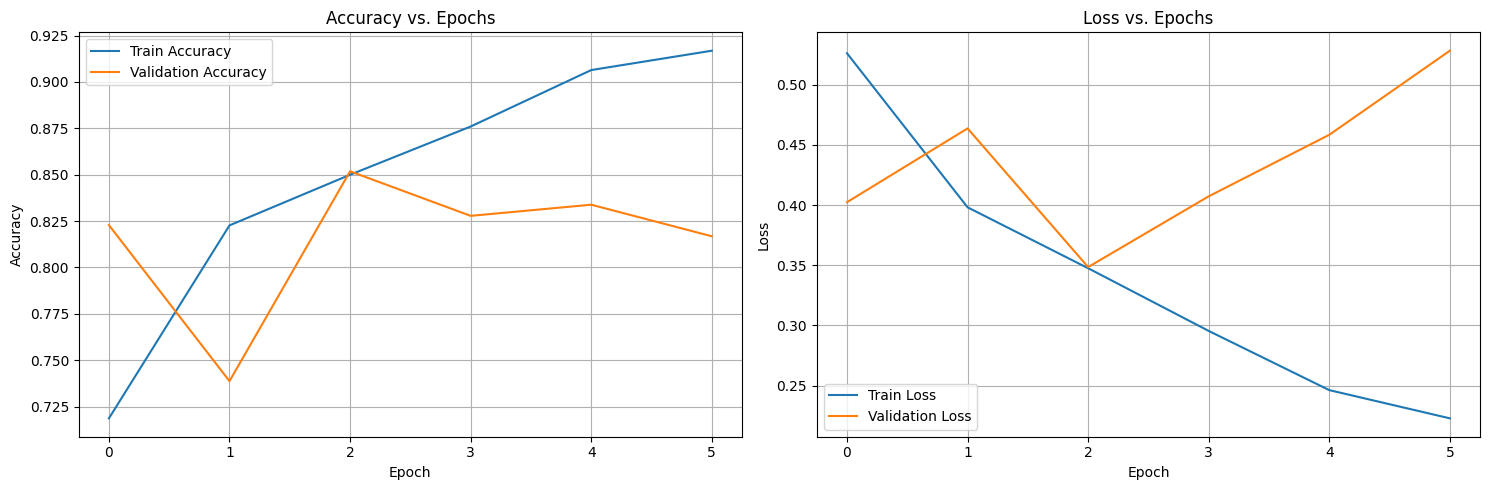

In [ ]:
# Initialize model
print("Initializing model...")
model = MultiModalFakeNewsDetector()
model.to(device)

# Print model summary
from torchsummary import summary
print("Model architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

# Set up loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()

# Use different learning rates for different parts of the model
optimizer = torch.optim.AdamW([
    {'params': model.bert.parameters(), 'lr': 2e-5},
    {'params': model.image_feature_extractor.parameters(), 'lr': 1e-5},
    {'params': model.text_fc.parameters()},
    {'params': model.img_fc.parameters()},
    {'params': model.attention.parameters()},
    {'params': model.fusion_fc.parameters()}
], lr=5e-4, weight_decay=0.01)

# Learning rate scheduler
total_steps = len(train_loader) * 10  # 10 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=5e-4,
    total_steps=total_steps,
    pct_start=0.1
)

# Train the model
print("Starting training...")
start_time = time.time()

# Use gradient accumulation steps to simulate larger batch sizes
gradient_accumulation_steps = 2 if torch.cuda.is_available() else 4

model, history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs=10, patience=3,
    gradient_accumulation_steps=gradient_accumulation_steps
)

training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

# Plot training history
plot_history(history)

Loading best model for evaluation...
Evaluating model...


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]



Test Results:
Accuracy: 0.8519
Precision: 0.8520
Recall: 0.8519
F1 Score: 0.8519


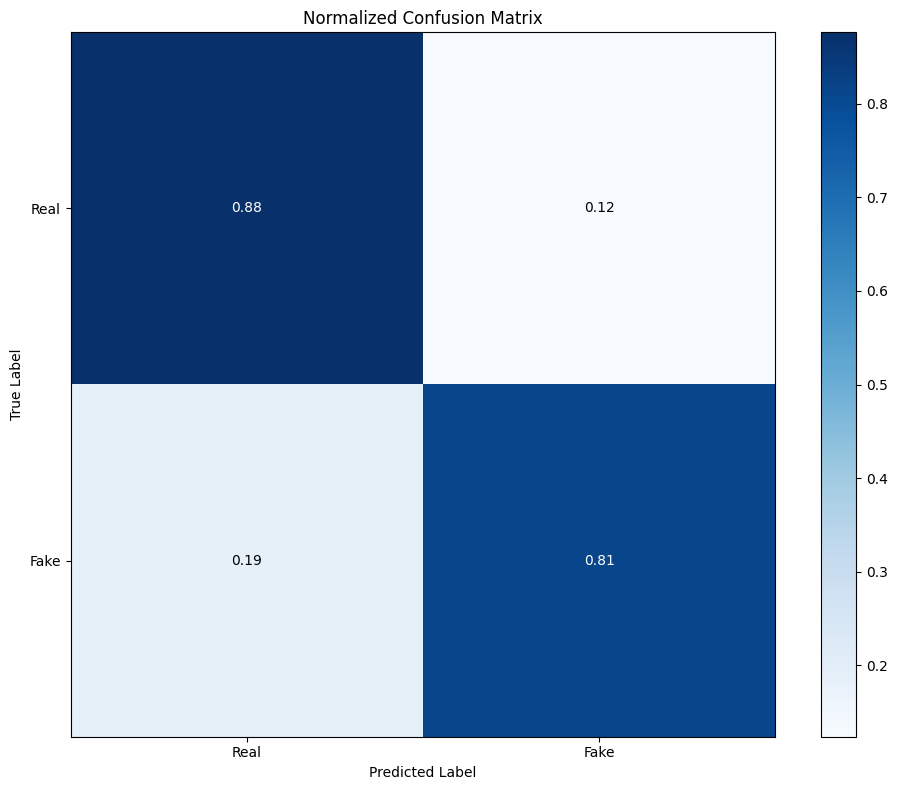

Model and results saved to fake_news_detector_model.pt


In [ ]:
# Load best model for evaluation
print("Loading best model for evaluation...")
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on validation set
print("Evaluating model...")
accuracy, precision, recall, f1 = evaluate_model(model, val_loader)

# Save model and results
model_save_path = 'fake_news_detector_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
}, model_save_path)

print(f"Model and results saved to {model_save_path}")

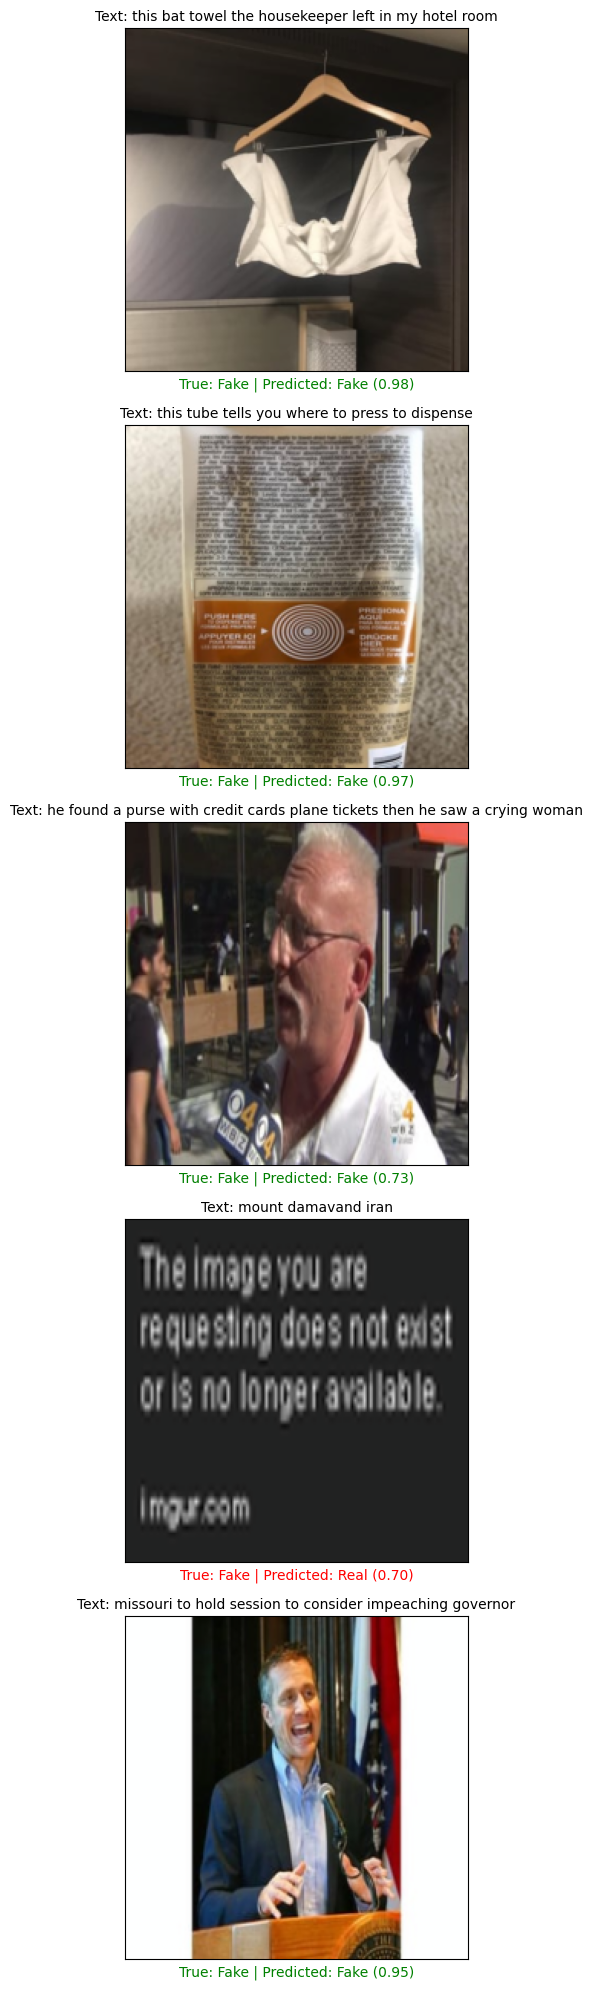

In [ ]:
# Function to visualize predictions on some examples
def visualize_predictions(model, test_loader, num_examples=5):
    """
    Visualize model predictions on some examples
    """
    model.eval()
    examples_seen = 0
    examples = []

    with torch.no_grad():
        for batch in test_loader:
            if examples_seen >= num_examples:
                break

            # Get inputs and labels
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Get model predictions
            outputs = model(input_ids, attention_mask, token_type_ids, images)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            # Get examples from this batch
            for i in range(min(len(labels), num_examples - examples_seen)):
                # Convert image tensor to numpy array for visualization
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                # Denormalize image
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                # Get text
                text = tokenizer.decode(input_ids[i], skip_special_tokens=True)

                # Get prediction info
                pred_label = predicted[i].item()
                true_label = labels[i].item()
                pred_prob = probabilities[i, pred_label].item()

                examples.append({
                    'image': img,
                    'text': text,
                    'pred_label': 'Fake' if pred_label == 1 else 'Real',
                    'true_label': 'Fake' if true_label == 1 else 'Real',
                    'prob': pred_prob,
                    'correct': pred_label == true_label
                })

                examples_seen += 1
                if examples_seen >= num_examples:
                    break

    # Visualize the examples
    fig, axes = plt.subplots(num_examples, 1, figsize=(12, 4 * num_examples))

    for i, example in enumerate(examples):
        ax = axes[i]
        ax.imshow(example['image'])

        # Set title with text
        ax.set_title(f"Text: {example['text']}", fontsize=10)

        # Set color based on prediction correctness
        color = 'green' if example['correct'] else 'red'

        # Set prediction info as xlabel
        ax.set_xlabel(
            f"True: {example['true_label']} | Predicted: {example['pred_label']} ({example['prob']:.2f})",
            color=color, fontsize=10
        )

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader, num_examples=5)

In [ ]:
# Analysis
class_report = f"""
# Multi-Modal Fake News Detection - Results and Analysis

## Performance Metrics
- Accuracy: {accuracy:.4f}
- Precision: {precision:.4f}
- Recall: {recall:.4f}
- F1 Score: {f1:.4f}

"""

print(class_report)

# Save analysis
with open('model_analysis.md', 'w') as f:
    f.write(class_report)


# Multi-Modal Fake News Detection - Results and Analysis

## Performance Metrics
- Accuracy: 0.8519
- Precision: 0.8520
- Recall: 0.8519
- F1 Score: 0.8519


